In [1]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 180)

In [10]:
library(tidyverse)
library(cowplot)
library(lubridate)

Warning message:
“package ‘lubridate’ was built under R version 3.6.2”

Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# Data prep

In [3]:
setwd('../BSD-QBio6/tutorials/stats_for_large_data/')

[1] "/Users/chaodai/qBio/qBioChallenges"

In [87]:
covid19 = read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')

Parsed with column specification:
cols(
  dateRep = col_character(),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2019 = col_double(),
  continentExp = col_character(),
  `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000` = col_double()
)



In [88]:
covid19 = mutate_at(covid19, 'dateRep', dmy) %>%
            filter(!is.na(countryterritoryCode) & !is.na(`Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`))

In [94]:
covid19 %>% tail

dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,firstLetterIndex
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2020-04-08,8,4,2020,1,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.05462439,26
2020-04-07,7,4,2020,0,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.04779634,26
2020-04-06,6,4,2020,0,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.04779634,26
2020-04-05,5,4,2020,0,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.04779634,26
2020-04-04,4,4,2020,1,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.05462439,26
2020-04-03,3,4,2020,0,0,Zimbabwe,ZW,ZWE,14645473,Africa,0.05462439,26


In [95]:
firstLetterIndex = str_extract(covid19$countryterritoryCode, '^[A-Z]')  %>%
    map_dbl(., ~ which(LETTERS == .x))
covid19$firstLetterIndex = firstLetterIndex

In [96]:
covid19$year %>% unique

[1] 2020

In [113]:
x = lm(deaths ~ cases, covid19)

In [136]:
summary(x) %>% .$coef %>% as.vector

[1] 7.313680e+00 2.164670e-02 4.489420e-01 1.001256e-04 1.629093e+01
[6] 2.161955e+02 1.774431e-59 0.000000e+00

In [137]:
summary(x) %>% .$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),7.3136804,0.4489419872,16.29093,1.774431e-59
cases,0.0216467,0.0001001256,216.19554,0.000000e+00


In [284]:
map_dbl(model, ~ coef(summary(.x))[2,4])

[1] FALSE

In [347]:
covid19 %>% dim

[1] 40310    13

In [373]:
x = select(covid19, dateRep, day, month, cases, deaths, `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`, firstLetterIndex) %>%
    group_by(dateRep) %>%
    nest %>%
    transmute(model = map(data, ~ lm(`Cumulative_number_for_14_days_of_COVID-19_cases_per_100000` ~ firstLetterIndex, data = .x)) ) %>%
    mutate(model.intercept = map_dbl(model, ~ coef(.x) %>% .[1])) %>%
    mutate(model.slope = map_dbl(model, ~ coef(.x) %>% .[2])) %>%
    mutate(slope.p = ifelse(is.na(model.slope), NA, map_dbl(model, ~ coef(summary(.x))[2,4]))
          )

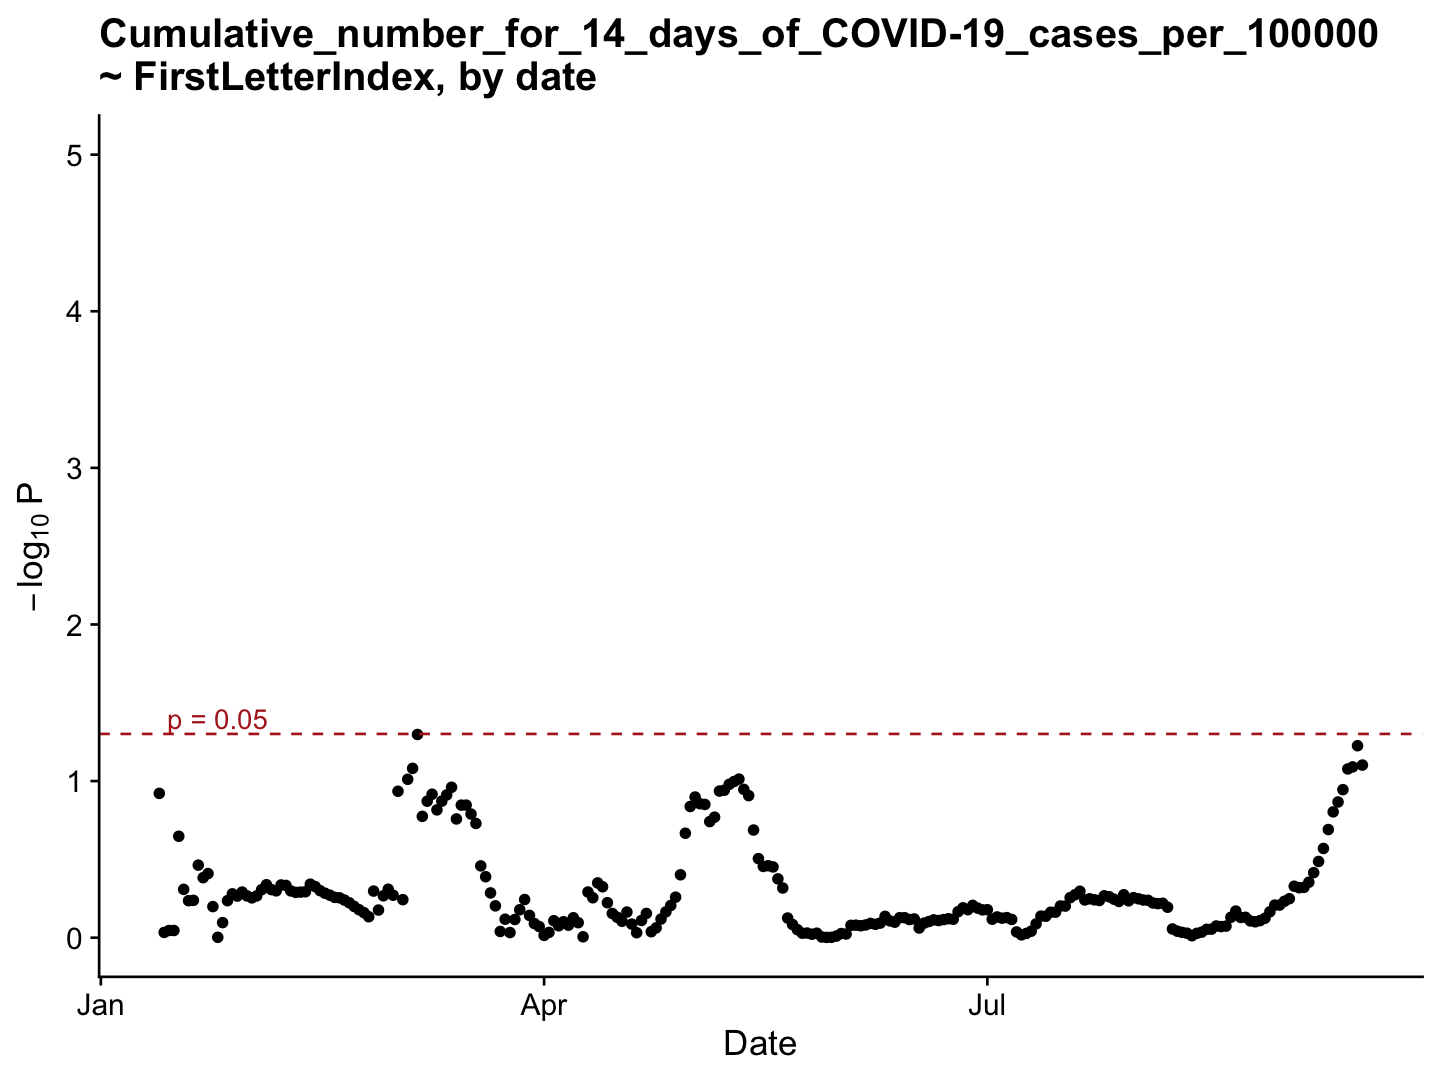

In [401]:
select(x, -model) %>% ggplot(aes(x = dateRep, y = -log10(slope.p))) +
    geom_point() +
    geom_hline(yintercept = -log10(.05), linetype = 'dashed', color = 'firebrick') +
    theme_cowplot() +
    ylim(c(0, 5)) +
    annotate('text', x = ymd('2020-01-25'), y = 1.4, label = 'p = 0.05', color = 'firebrick') +
    labs(x = 'Date', y = bquote(-log[10]~"P"), title = "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 \n~ FirstLetterIndex, by date")

In [402]:
y = select(covid19, dateRep, day, month, cases, deaths, `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`, firstLetterIndex) %>%
    group_by(month) %>%
    nest %>%
    transmute(model = map(data, ~ lm(`Cumulative_number_for_14_days_of_COVID-19_cases_per_100000` ~ firstLetterIndex, data = .x)) ) %>%
    mutate(model.intercept = map_dbl(model, ~ coef(.x) %>% .[1])) %>%
    mutate(model.slope = map_dbl(model, ~ coef(.x) %>% .[2])) %>%
    mutate(slope.p = ifelse(is.na(model.slope), NA, map_dbl(model, ~ coef(summary(.x))[2,4]))
          )

In [403]:
select(y, -model) %>% head(2)

month,model.intercept,model.slope,slope.p
<dbl>,<dbl>,<dbl>,<dbl>
9,72.52604,-1.28716101,1.169880e-06
8,53.90939,-0.09907325,5.557811e-01


Warning message:
“Removed 2 rows containing missing values (geom_point).”


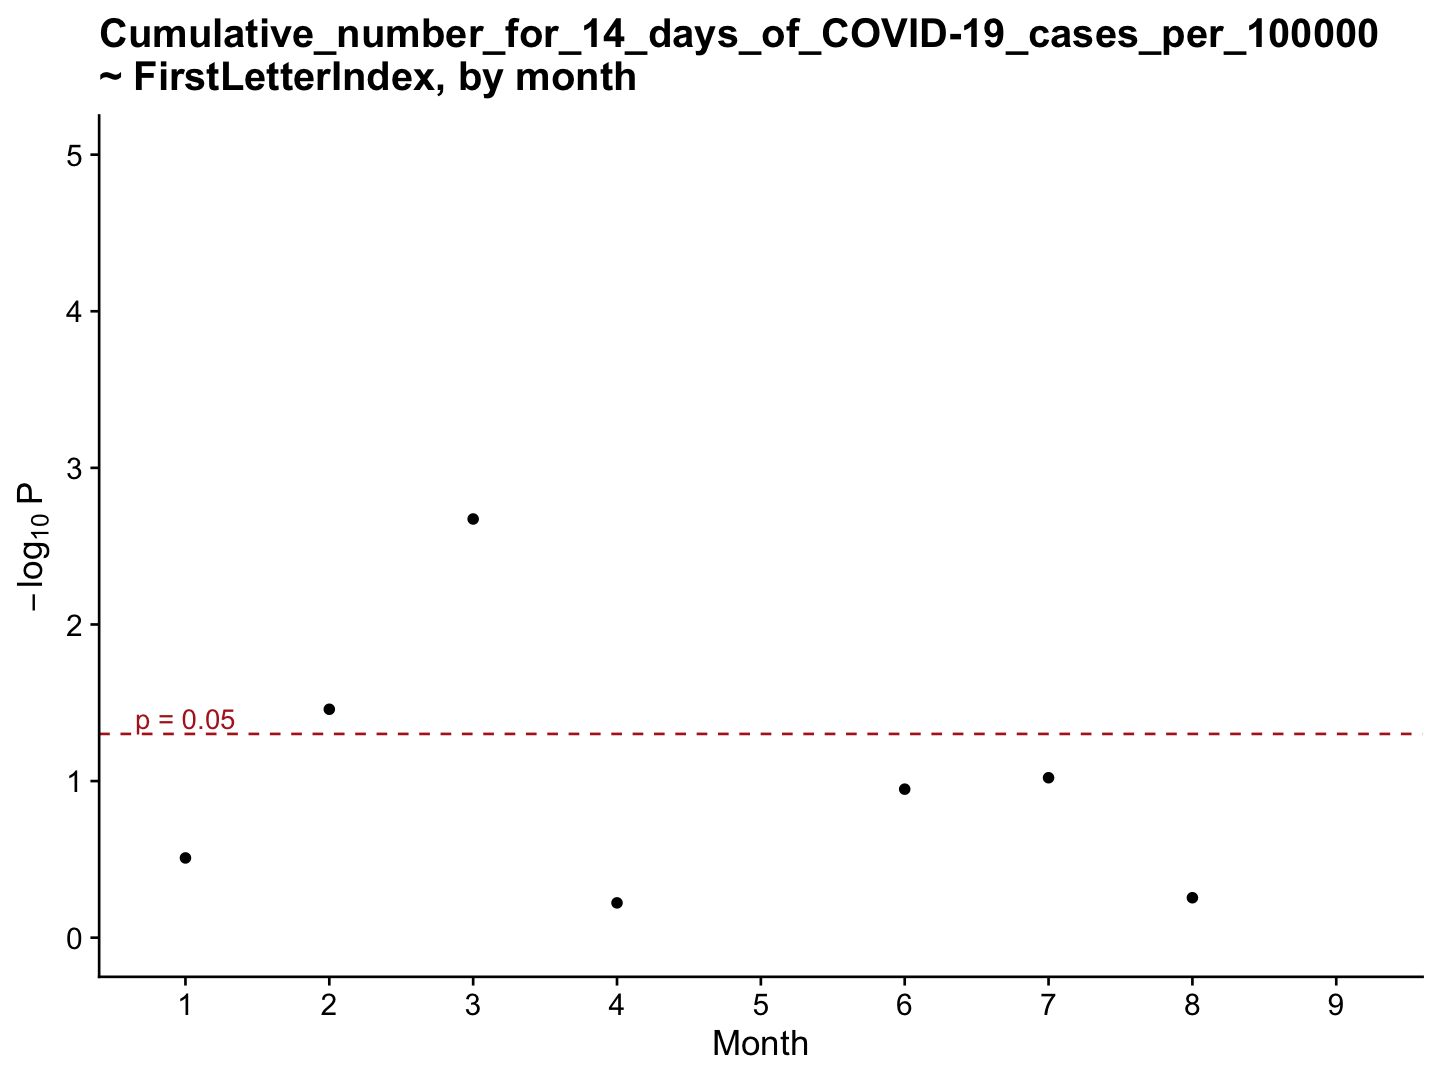

In [408]:
select(y, -model) %>% mutate_at('month', factor) %>% ggplot(aes(x = month, y = -log10(slope.p))) +
    geom_point() +
    geom_hline(yintercept = -log10(.05), linetype = 'dashed', color = 'firebrick') +
    theme_cowplot() +
    ylim(c(0, 5)) +
    annotate('text', x = 1, y = 1.4, label = 'p = 0.05', color = 'firebrick') +
    labs(x = 'Month', y = bquote(-log[10]~"P"), title = "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 \n~ FirstLetterIndex, by month")

In [383]:
?geom_text

geom_label {ggplot2},R Documentation
mapping,"Set of aesthetic mappings created by aes() or aes_(). If specified and inherit.aes = TRUE (the default), it is combined with the default mapping at the top level of the plot. You must supply mapping if there is no plot mapping."
data,"The data to be displayed in this layer. There are three options: If NULL, the default, the data is inherited from the plot data as specified in the call to ggplot(). A data.frame, or other object, will override the plot data. All objects will be fortified to produce a data frame. See fortify() for which variables will be created. A function will be called with a single argument, the plot data. The return value must be a data.frame, and will be used as the layer data. A function can be created from a formula (e.g. ~ head(.x, 10))."
stat,"The statistical transformation to use on the data for this layer, as a string."
position,"Position adjustment, either as a string, or the result of a call to a position adjustment function. Cannot be jointy specified with nudge_x or nudge_y."
...,"Other arguments passed on to layer(). These are often aesthetics, used to set an aesthetic to a fixed value, like colour = ""red"" or size = 3. They may also be parameters to the paired geom/stat."
parse,"If TRUE, the labels will be parsed into expressions and displayed as described in ?plotmath."
"nudge_x, nudge_y","Horizontal and vertical adjustment to nudge labels by. Useful for offsetting text from points, particularly on discrete scales. Cannot be jointly specified with position."
label.padding,Amount of padding around label. Defaults to 0.25 lines.
label.r,Radius of rounded corners. Defaults to 0.15 lines.
label.size,"Size of label border, in mm."
